In [1]:
import torch, torchvision
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
import timm
import os, glob
from zipfile import ZipFile
from collections import defaultdict
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold

C:\Users\82103\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd Desktop/git_repos/Algorithm_study/Programmers/Task_test/classificaition_art/

C:\Users\82103\Desktop\git_repos\Algorithm_study\Programmers\Task_test\classificaition_art


In [38]:
train_data_path = './train/'
test_data_path = './test/'

img_path_list = []
img_label_list = []

for idx, label in enumerate(os.listdir(train_data_path)):
    for img_path in glob.glob(os.path.join(train_data_path, label, '*.jpg')):
        img_path_list.append(img_path)
        img_label_list.append(idx)

print(img_path_list[-10:], img_label_list[-10:])
img_list = pd.DataFrame(data=dict(path=img_path_list,label=img_label_list))

test_image_path =[]
test_label = []
for label in os.listdir(test_data_path):
    for img_path in glob.glob(os.path.join(test_data_path, label, '*.jpg')):
        test_image_path.append(img_path)
        test_label.append(label)
        
test_list = pd.DataFrame(data=dict(path=test_image_path, label=test_label))

['./train/person\\pic_501.jpg', './train/person\\pic_502.jpg', './train/person\\pic_503.jpg', './train/person\\pic_504.jpg', './train/person\\pic_505.jpg', './train/person\\pic_506.jpg', './train/person\\pic_507.jpg', './train/person\\pic_508.jpg', './train/person\\pic_510.jpg', './train/person\\pic_511.jpg'] [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [4]:


with ZipFile('./train.zip', 'r') as z_file:
    file_list = z_file.namelist()
    
file_list = [f for f in file_list if f.endswith('jpg')]
print(file_list[0])

train/dog/pic_001.jpg


<BarContainer object of 7 artists>

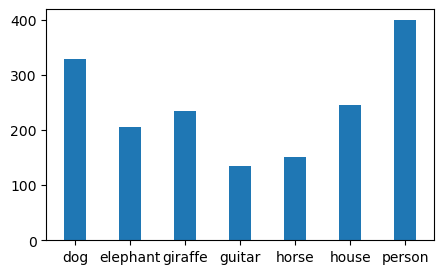

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

count = defaultdict(int)

for f in file_list:
    label = f.split('/')[1]
    count[label] += 1

plt.figure(figsize=(5, 3))
plt.bar(count.keys(), count.values(),width=0.4)

In [6]:
class cfg:
    num_classes = 7
    learning_rate = 0.001
    batch_size = 100
    num_workers = 0
    epochs = 100

In [7]:
def seed_management(seed: int = 999):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministric = True
    torch.backends.cudnn.benchmark = True

In [8]:
train_transform = album.Compose([
    album.HorizontalFlip(p=0.5),
    album.ToGray(p=0.5),
    album.Blur(p=0.5),
    album.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    album.Resize(224, 224),
    album.Normalize(mean=(0.4569, 0.5074, 0.5557), std=(0.2888, 0.2743, 0.2829)),
    ToTensorV2()
])

val_transform = album.Compose([
    album.Resize(224, 224),
    album.Normalize(mean=(0.4569, 0.5074, 0.5557), std=(0.2888, 0.2743, 0.2829)),
    ToTensorV2()
])

In [9]:
print(timm.list_models('*resnet18*'))

class FineTunedModel(torch.nn.Module):
    def __init__(self, model_str='resnet18'):
        super().__init__()
        self.net = timm.create_model(model_str, pretrained=True, num_classes=cfg.num_classes)
    
    def forward(self, x):
        x = self.net(x)
        
        return x

['legacy_seresnet18', 'resnet18', 'resnet18d', 'seresnet18', 'skresnet18']


In [37]:
class myDataset(Dataset):
    def __init__(self, data, transforms=None):
        super().__init__()
        self.data = data.reset_index()
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img = self.data['path'][idx]
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        return {'img' : img, 'label' : self.data['label'][idx]}
        
        
    def __len__(self):
        return len(self.data)

In [11]:
class AvgMeter(object):
    def __init__(self):
        super().__init__()
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class AccMeter(object):
    def __init__(self):
        super().__init__()
        
    def accuracy(self, labels, pred):
        batch_size = labels.size(0)
        pred_topk = pred.topk(k=5)[1]
        labels = labels.view(-1,1).expand_as(pred_topk)
        
        match = pred_topk.eq(labels)
        
        result = []
        for k in [1, 5]:
            correct = match[:, :k].reshape(-1).sum(0, keepdim=True).item()
            
            result.append((correct / batch_size) * 100)
            
        return result
            

In [19]:
def train(*args, **kwargs):
    k = kwargs['k']
    train_loader = kwargs['train_dataloader']
    valid_loader = kwargs['valid_dataloader']
    cfg = kwargs['cfg']
    
    model = FineTunedModel()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    best_acc = 0.0
    
    for epoch in range(cfg.epochs):
        model.train()
        acc_meter = AccMeter()
        loss_avg = AvgMeter()
        acc_top1 = AvgMeter()
        acc_top5 = AvgMeter()
        
        for batch_idx, batch in enumerate(train_loader):
            imgs = batch['img']
            labels = batch['label']
            
            imgs = imgs.float().to(device)
            labels = labels.long().to(device)
            
            optimizer.zero_grad()
            
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            
            optimizer.step()
            
            #Average update
            top1, top5 = acc_meter.accuracy(labels, pred)
            
            loss_avg.update(loss.item(), 1)
            acc_top1.update(top1, cfg.batch_size)
            acc_top5.update(top5, cfg.batch_size)
            
            print(f'[Epoch:{epoch + 1}/{cfg.epochs}][Batch:{batch_idx}/{len(train_loader)}] | Loss [batch/total][{loss_avg.val:.4f}/{loss_avg.avg:.4f}]\n Top1 acc [{acc_top1.val:.4f}/{acc_top1.avg:.4f}]\n Top5 acc [{acc_top5.val:.4f}/{acc_top5.avg:.4f}]')
        print('=' * 50)
        
        with torch.no_grad():
            model.eval()
            loss_avg = AvgMeter()
            acc_top1 = AvgMeter()
            acc_top5 = AvgMeter()
            for batch_idx, batch in enumerate(valid_loader):
                imgs = batch['img']
                labels = batch['label']
                
                imgs = imgs.float().to(device)
                labels = labels.long().to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                top1, top5 = acc_meter.accuracy(labels, pred)
                loss_avg.update(loss.item(), 1)
                acc_top1.update(top1, cfg.batch_size)
                acc_top5.update(top5, cfg.batch_size)
                
            print(f'[Epoch:{epoch + 1}/{cfg.epochs}] | Loss : {loss_avg.avg:.4f} | valid top1 : {acc_top1.avg:.4f} | top5 : {acc_top5.avg}')
            model_path = 'C:/Users/82103/Desktop/git_repos/Algorithm_study/Programmers/Task_test/classificaition_art/test_01/saved_models'
            if best_acc < acc_top1.avg:
                torch.save(model.state_dict(), os.path.join(model_path, f'K{k}_E{epoch+1}_{acc_top1.avg:.3f}.pth'))
                best_acc = acc_top1.avg
                
                
                

In [20]:
kfold = StratifiedKFold(n_splits=5)

for k_i, (train_idx, val_idx) in enumerate(kfold.split(img_list['path'], img_list['label'])):
    print(len(train_idx), len(val_idx))
    train_df = img_list.iloc[train_idx]
    val_df = img_list.iloc[val_idx]
    
    train_dataset = myDataset(train_df, train_transform)
    valid_dataset = myDataset(val_df, val_transform)
    
    
    train_loader = DataLoader(dataset=train_dataset,
                             batch_size=cfg.batch_size,
                             shuffle=True,
                             num_workers=cfg.num_workers)
    
    val_loader = DataLoader(dataset=valid_dataset,
                           batch_size=cfg.batch_size,
                           shuffle=False,
                           num_workers=cfg.num_workers)
    
    train(cfg=cfg, k=k_i, train_dataloader=train_loader, valid_dataloader=val_loader)

1358 340
[Epoch:1/100][Batch:0/14] | Loss [batch/total][1.9448/1.9448]
 Top1 acc [15.0000/15.0000]
 Top5 acc [76.0000/76.0000]
[Epoch:1/100][Batch:1/14] | Loss [batch/total][1.9066/1.9257]
 Top1 acc [24.0000/19.5000]
 Top5 acc [78.0000/77.0000]
[Epoch:1/100][Batch:2/14] | Loss [batch/total][1.8753/1.9089]
 Top1 acc [19.0000/19.3333]
 Top5 acc [84.0000/79.3333]
[Epoch:1/100][Batch:3/14] | Loss [batch/total][1.7829/1.8774]
 Top1 acc [35.0000/23.2500]
 Top5 acc [95.0000/83.2500]
[Epoch:1/100][Batch:4/14] | Loss [batch/total][1.6828/1.8385]
 Top1 acc [38.0000/26.2000]
 Top5 acc [94.0000/85.4000]
[Epoch:1/100][Batch:5/14] | Loss [batch/total][1.6800/1.8121]
 Top1 acc [40.0000/28.5000]
 Top5 acc [96.0000/87.1667]
[Epoch:1/100][Batch:6/14] | Loss [batch/total][1.5748/1.7782]
 Top1 acc [47.0000/31.1429]
 Top5 acc [92.0000/87.8571]
[Epoch:1/100][Batch:7/14] | Loss [batch/total][1.5581/1.7507]
 Top1 acc [46.0000/33.0000]
 Top5 acc [92.0000/88.3750]
[Epoch:1/100][Batch:8/14] | Loss [batch/total][

[Epoch:5/100][Batch:9/14] | Loss [batch/total][0.2764/0.1917]
 Top1 acc [89.0000/94.3000]
 Top5 acc [100.0000/99.8000]
[Epoch:5/100][Batch:10/14] | Loss [batch/total][0.1020/0.1836]
 Top1 acc [98.0000/94.6364]
 Top5 acc [100.0000/99.8182]
[Epoch:5/100][Batch:11/14] | Loss [batch/total][0.1839/0.1836]
 Top1 acc [92.0000/94.4167]
 Top5 acc [100.0000/99.8333]
[Epoch:5/100][Batch:12/14] | Loss [batch/total][0.2020/0.1850]
 Top1 acc [90.0000/94.0769]
 Top5 acc [100.0000/99.8462]
[Epoch:5/100][Batch:13/14] | Loss [batch/total][0.1372/0.1816]
 Top1 acc [96.5517/94.2537]
 Top5 acc [100.0000/99.8571]
[Epoch:5/100] | Loss : 0.1974 | valid top1 : 92.6250 | top5 : 100.0
[Epoch:6/100][Batch:0/14] | Loss [batch/total][0.1130/0.1130]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:6/100][Batch:1/14] | Loss [batch/total][0.0939/0.1034]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:6/100][Batch:2/14] | Loss [batch/total][0.1100/0.1056]
 Top1 acc [97.0000/97.6667]
 To

[Epoch:10/100][Batch:3/14] | Loss [batch/total][0.0504/0.1137]
 Top1 acc [99.0000/96.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:4/14] | Loss [batch/total][0.0404/0.0990]
 Top1 acc [99.0000/97.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:5/14] | Loss [batch/total][0.0717/0.0945]
 Top1 acc [98.0000/97.1667]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:6/14] | Loss [batch/total][0.0268/0.0848]
 Top1 acc [99.0000/97.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:7/14] | Loss [batch/total][0.0315/0.0782]
 Top1 acc [100.0000/97.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:8/14] | Loss [batch/total][0.0636/0.0765]
 Top1 acc [99.0000/97.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:9/14] | Loss [batch/total][0.0618/0.0751]
 Top1 acc [99.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:10/14] | Loss [batch/total][0.1238/0.0795]
 Top1 acc [96.0000/97.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:11/14] | 

[Epoch:14/100][Batch:11/14] | Loss [batch/total][0.0190/0.0291]
 Top1 acc [100.0000/99.4167]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:12/14] | Loss [batch/total][0.0315/0.0293]
 Top1 acc [100.0000/99.4615]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:13/14] | Loss [batch/total][0.1801/0.0401]
 Top1 acc [96.5517/99.2537]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100] | Loss : 0.1963 | valid top1 : 94.7500 | top5 : 100.0
[Epoch:15/100][Batch:0/14] | Loss [batch/total][0.0142/0.0142]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:15/100][Batch:1/14] | Loss [batch/total][0.0175/0.0158]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:15/100][Batch:2/14] | Loss [batch/total][0.0121/0.0146]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:15/100][Batch:3/14] | Loss [batch/total][0.0130/0.0142]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:15/100][Batch:4/14] | Loss [batch/total][0.0143/0.0142]
 Top1 ac

[Epoch:19/100][Batch:4/14] | Loss [batch/total][0.0656/0.0305]
 Top1 acc [98.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:5/14] | Loss [batch/total][0.0131/0.0276]
 Top1 acc [100.0000/99.1667]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:6/14] | Loss [batch/total][0.0518/0.0311]
 Top1 acc [98.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:7/14] | Loss [batch/total][0.0578/0.0344]
 Top1 acc [98.0000/98.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:8/14] | Loss [batch/total][0.0220/0.0330]
 Top1 acc [99.0000/98.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:9/14] | Loss [batch/total][0.0494/0.0347]
 Top1 acc [99.0000/98.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:10/14] | Loss [batch/total][0.0069/0.0321]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:11/14] | Loss [batch/total][0.0470/0.0334]
 Top1 acc [98.0000/98.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:12/14] 

[Epoch:23/100][Batch:12/14] | Loss [batch/total][0.0543/0.0371]
 Top1 acc [98.0000/98.9231]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:13/14] | Loss [batch/total][0.0459/0.0377]
 Top1 acc [96.5517/98.7537]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100] | Loss : 0.3366 | valid top1 : 90.5000 | top5 : 100.0
[Epoch:24/100][Batch:0/14] | Loss [batch/total][0.0174/0.0174]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:24/100][Batch:1/14] | Loss [batch/total][0.0228/0.0201]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:24/100][Batch:2/14] | Loss [batch/total][0.0207/0.0203]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:24/100][Batch:3/14] | Loss [batch/total][0.0252/0.0215]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:24/100][Batch:4/14] | Loss [batch/total][0.0071/0.0186]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:24/100][Batch:5/14] | Loss [batch/total][0.0201/0.0189]
 Top1 acc [99.00

[Epoch:28/100][Batch:5/14] | Loss [batch/total][0.0054/0.0128]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:6/14] | Loss [batch/total][0.0054/0.0117]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:7/14] | Loss [batch/total][0.0037/0.0107]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:8/14] | Loss [batch/total][0.0211/0.0119]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:9/14] | Loss [batch/total][0.0050/0.0112]
 Top1 acc [100.0000/99.7000]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:10/14] | Loss [batch/total][0.0161/0.0116]
 Top1 acc [99.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:11/14] | Loss [batch/total][0.0034/0.0109]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:12/14] | Loss [batch/total][0.0016/0.0102]
 Top1 acc [100.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:13

[Epoch:32/100][Batch:12/14] | Loss [batch/total][0.0025/0.0053]
 Top1 acc [100.0000/99.9231]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:13/14] | Loss [batch/total][0.0463/0.0082]
 Top1 acc [98.2759/99.8054]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100] | Loss : 0.1576 | valid top1 : 95.3750 | top5 : 100.0
[Epoch:33/100][Batch:0/14] | Loss [batch/total][0.0021/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:33/100][Batch:1/14] | Loss [batch/total][0.0025/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:33/100][Batch:2/14] | Loss [batch/total][0.0021/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:33/100][Batch:3/14] | Loss [batch/total][0.0032/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:33/100][Batch:4/14] | Loss [batch/total][0.0013/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:33/100][Batch:5/14] | Loss [batch/total][0.0282/0.0066]
 Top1 ac

[Epoch:37/100][Batch:5/14] | Loss [batch/total][0.0128/0.0170]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:6/14] | Loss [batch/total][0.0207/0.0175]
 Top1 acc [100.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:7/14] | Loss [batch/total][0.0155/0.0173]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:8/14] | Loss [batch/total][0.0127/0.0168]
 Top1 acc [99.0000/99.4444]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:9/14] | Loss [batch/total][0.0090/0.0160]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:10/14] | Loss [batch/total][0.0027/0.0148]
 Top1 acc [100.0000/99.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:11/14] | Loss [batch/total][0.0255/0.0157]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:12/14] | Loss [batch/total][0.0144/0.0156]
 Top1 acc [99.0000/99.4615]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:13/1

[Epoch:41/100][Batch:13/14] | Loss [batch/total][0.0019/0.0086]
 Top1 acc [100.0000/99.7857]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100] | Loss : 0.1560 | valid top1 : 95.0000 | top5 : 100.0
[Epoch:42/100][Batch:0/14] | Loss [batch/total][0.0131/0.0131]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:1/14] | Loss [batch/total][0.0088/0.0109]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:2/14] | Loss [batch/total][0.0039/0.0086]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:3/14] | Loss [batch/total][0.0050/0.0077]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:4/14] | Loss [batch/total][0.0039/0.0069]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:5/14] | Loss [batch/total][0.0069/0.0069]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:42/100][Batch:6/14] | Loss [batch/total][0.0040/0.0065]
 Top1 acc [100

[Epoch:46/100][Batch:6/14] | Loss [batch/total][0.0033/0.0141]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:7/14] | Loss [batch/total][0.0092/0.0135]
 Top1 acc [100.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:8/14] | Loss [batch/total][0.0404/0.0165]
 Top1 acc [98.0000/99.4444]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:9/14] | Loss [batch/total][0.0145/0.0163]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:10/14] | Loss [batch/total][0.0122/0.0159]
 Top1 acc [99.0000/99.4545]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:11/14] | Loss [batch/total][0.0042/0.0149]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:12/14] | Loss [batch/total][0.0125/0.0148]
 Top1 acc [100.0000/99.5385]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:13/14] | Loss [batch/total][0.0090/0.0143]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100] | Loss 

[Epoch:50/100] | Loss : 0.1891 | valid top1 : 93.6250 | top5 : 100.0
[Epoch:51/100][Batch:0/14] | Loss [batch/total][0.0042/0.0042]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:1/14] | Loss [batch/total][0.0010/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:2/14] | Loss [batch/total][0.0104/0.0052]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:3/14] | Loss [batch/total][0.0072/0.0057]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:4/14] | Loss [batch/total][0.0063/0.0058]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:5/14] | Loss [batch/total][0.0098/0.0065]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:6/14] | Loss [batch/total][0.0050/0.0063]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:51/100][Batch:7/14] | Loss [batch/total][0.0028/0.0058]
 Top1 a

[Epoch:55/100][Batch:7/14] | Loss [batch/total][0.0030/0.0074]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:8/14] | Loss [batch/total][0.0020/0.0068]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:9/14] | Loss [batch/total][0.0450/0.0106]
 Top1 acc [97.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:10/14] | Loss [batch/total][0.0016/0.0098]
 Top1 acc [100.0000/99.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:11/14] | Loss [batch/total][0.0020/0.0091]
 Top1 acc [100.0000/99.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:12/14] | Loss [batch/total][0.0028/0.0086]
 Top1 acc [100.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:13/14] | Loss [batch/total][0.0005/0.0081]
 Top1 acc [100.0000/99.6429]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100] | Loss : 0.1484 | valid top1 : 95.8750 | top5 : 100.0
[Epoch:56/100][Batch:0/14] | Loss [batch/total][0.0013/0.0013]
 Top1 acc [

[Epoch:59/100] | Loss : 0.1740 | valid top1 : 95.7500 | top5 : 100.0
[Epoch:60/100][Batch:0/14] | Loss [batch/total][0.0026/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:1/14] | Loss [batch/total][0.0349/0.0188]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:2/14] | Loss [batch/total][0.0180/0.0185]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:3/14] | Loss [batch/total][0.0131/0.0172]
 Top1 acc [99.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:4/14] | Loss [batch/total][0.0260/0.0189]
 Top1 acc [98.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:5/14] | Loss [batch/total][0.0013/0.0160]
 Top1 acc [100.0000/99.1667]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:6/14] | Loss [batch/total][0.0873/0.0262]
 Top1 acc [99.0000/99.1429]
 Top5 acc [100.0000/100.0000]
[Epoch:60/100][Batch:7/14] | Loss [batch/total][0.0067/0.0237]
 Top1 acc [100.000

[Epoch:64/100][Batch:7/14] | Loss [batch/total][0.0169/0.0107]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:8/14] | Loss [batch/total][0.0243/0.0122]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:9/14] | Loss [batch/total][0.0005/0.0110]
 Top1 acc [100.0000/99.7000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:10/14] | Loss [batch/total][0.0021/0.0102]
 Top1 acc [100.0000/99.7273]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:11/14] | Loss [batch/total][0.0057/0.0098]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:12/14] | Loss [batch/total][0.0276/0.0112]
 Top1 acc [98.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:13/14] | Loss [batch/total][0.0236/0.0121]
 Top1 acc [98.2759/99.5197]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100] | Loss : 0.2530 | valid top1 : 93.8750 | top5 : 100.0
[Epoch:65/100][Batch:0/14] | Loss [batch/total][0.0067/0.0067]
 Top1 acc [100

[Epoch:68/100] | Loss : 0.2373 | valid top1 : 93.5000 | top5 : 100.0
[Epoch:69/100][Batch:0/14] | Loss [batch/total][0.0074/0.0074]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:1/14] | Loss [batch/total][0.0022/0.0048]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:2/14] | Loss [batch/total][0.0041/0.0046]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:3/14] | Loss [batch/total][0.0082/0.0055]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:4/14] | Loss [batch/total][0.0041/0.0052]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:5/14] | Loss [batch/total][0.0015/0.0046]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:6/14] | Loss [batch/total][0.0012/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:69/100][Batch:7/14] | Loss [batch/total][0.0006/0.0036]
 Top1 a

[Epoch:73/100][Batch:7/14] | Loss [batch/total][0.0060/0.0078]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:8/14] | Loss [batch/total][0.0064/0.0077]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:9/14] | Loss [batch/total][0.0016/0.0071]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:10/14] | Loss [batch/total][0.0081/0.0071]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:11/14] | Loss [batch/total][0.0154/0.0078]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:12/14] | Loss [batch/total][0.0115/0.0081]
 Top1 acc [99.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:13/14] | Loss [batch/total][0.0044/0.0079]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100] | Loss : 0.2584 | valid top1 : 94.0000 | top5 : 100.0
[Epoch:74/100][Batch:0/14] | Loss [batch/total][0.0012/0.0012]
 Top1 acc [1

[Epoch:77/100] | Loss : 0.1946 | valid top1 : 95.6250 | top5 : 99.75
[Epoch:78/100][Batch:0/14] | Loss [batch/total][0.0026/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:1/14] | Loss [batch/total][0.0004/0.0015]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:2/14] | Loss [batch/total][0.0030/0.0020]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:3/14] | Loss [batch/total][0.0024/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:4/14] | Loss [batch/total][0.0022/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:5/14] | Loss [batch/total][0.0024/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:6/14] | Loss [batch/total][0.0735/0.0124]
 Top1 acc [98.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:78/100][Batch:7/14] | Loss [batch/total][0.0083/0.0119]
 Top1 acc

[Epoch:82/100][Batch:7/14] | Loss [batch/total][0.0980/0.0213]
 Top1 acc [95.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:8/14] | Loss [batch/total][0.1163/0.0319]
 Top1 acc [97.0000/98.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:9/14] | Loss [batch/total][0.0124/0.0299]
 Top1 acc [99.0000/98.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:10/14] | Loss [batch/total][0.0050/0.0277]
 Top1 acc [100.0000/98.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:11/14] | Loss [batch/total][0.0245/0.0274]
 Top1 acc [98.0000/98.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:12/14] | Loss [batch/total][0.0110/0.0261]
 Top1 acc [99.0000/98.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:13/14] | Loss [batch/total][0.0815/0.0301]
 Top1 acc [94.8276/98.5591]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100] | Loss : 0.2311 | valid top1 : 94.6250 | top5 : 100.0
[Epoch:83/100][Batch:0/14] | Loss [batch/total][0.0352/0.0352]
 Top1 acc [99.00

[Epoch:86/100] | Loss : 0.2394 | valid top1 : 94.2500 | top5 : 100.0
[Epoch:87/100][Batch:0/14] | Loss [batch/total][0.0646/0.0646]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:1/14] | Loss [batch/total][0.0164/0.0405]
 Top1 acc [99.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:2/14] | Loss [batch/total][0.0132/0.0314]
 Top1 acc [99.0000/98.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:3/14] | Loss [batch/total][0.0063/0.0251]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:4/14] | Loss [batch/total][0.0115/0.0224]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:5/14] | Loss [batch/total][0.0061/0.0197]
 Top1 acc [100.0000/99.1667]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:6/14] | Loss [batch/total][0.0043/0.0175]
 Top1 acc [100.0000/99.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:87/100][Batch:7/14] | Loss [batch/total][0.0364/0.0199]
 Top1 acc [99.0000

[Epoch:91/100][Batch:7/14] | Loss [batch/total][0.0016/0.0101]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:8/14] | Loss [batch/total][0.0033/0.0093]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:9/14] | Loss [batch/total][0.0281/0.0112]
 Top1 acc [99.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:10/14] | Loss [batch/total][0.0201/0.0120]
 Top1 acc [99.0000/99.7273]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:11/14] | Loss [batch/total][0.0217/0.0128]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:12/14] | Loss [batch/total][0.0012/0.0119]
 Top1 acc [100.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:13/14] | Loss [batch/total][0.0042/0.0114]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100] | Loss : 0.2201 | valid top1 : 94.0000 | top5 : 100.0
[Epoch:92/100][Batch:0/14] | Loss [batch/total][0.0042/0.0042]
 Top1 acc [10

[Epoch:95/100] | Loss : 0.2161 | valid top1 : 94.6250 | top5 : 100.0
[Epoch:96/100][Batch:0/14] | Loss [batch/total][0.0052/0.0052]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:1/14] | Loss [batch/total][0.0009/0.0030]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:2/14] | Loss [batch/total][0.0024/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:3/14] | Loss [batch/total][0.0010/0.0024]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:4/14] | Loss [batch/total][0.0009/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:5/14] | Loss [batch/total][0.0061/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:6/14] | Loss [batch/total][0.0006/0.0024]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:96/100][Batch:7/14] | Loss [batch/total][0.0023/0.0024]
 Top1 a

[Epoch:100/100][Batch:6/14] | Loss [batch/total][0.0028/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:7/14] | Loss [batch/total][0.0027/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:8/14] | Loss [batch/total][0.0002/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:9/14] | Loss [batch/total][0.0035/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:10/14] | Loss [batch/total][0.0001/0.0020]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:11/14] | Loss [batch/total][0.0004/0.0019]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:12/14] | Loss [batch/total][0.0003/0.0018]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:13/14] | Loss [batch/total][0.0003/0.0017]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epo

[Epoch:5/100][Batch:0/14] | Loss [batch/total][0.1779/0.1779]
 Top1 acc [95.0000/95.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:5/100][Batch:1/14] | Loss [batch/total][0.1272/0.1525]
 Top1 acc [98.0000/96.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:5/100][Batch:2/14] | Loss [batch/total][0.1913/0.1654]
 Top1 acc [96.0000/96.3333]
 Top5 acc [99.0000/99.6667]
[Epoch:5/100][Batch:3/14] | Loss [batch/total][0.1851/0.1704]
 Top1 acc [94.0000/95.7500]
 Top5 acc [100.0000/99.7500]
[Epoch:5/100][Batch:4/14] | Loss [batch/total][0.2430/0.1849]
 Top1 acc [91.0000/94.8000]
 Top5 acc [100.0000/99.8000]
[Epoch:5/100][Batch:5/14] | Loss [batch/total][0.2751/0.1999]
 Top1 acc [92.0000/94.3333]
 Top5 acc [100.0000/99.8333]
[Epoch:5/100][Batch:6/14] | Loss [batch/total][0.1246/0.1892]
 Top1 acc [97.0000/94.7143]
 Top5 acc [100.0000/99.8571]
[Epoch:5/100][Batch:7/14] | Loss [batch/total][0.2142/0.1923]
 Top1 acc [94.0000/94.6250]
 Top5 acc [100.0000/99.8750]
[Epoch:5/100][Batch:8/14] | Loss [batch/total][

[Epoch:9/100][Batch:9/14] | Loss [batch/total][0.0678/0.0660]
 Top1 acc [97.0000/98.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:10/14] | Loss [batch/total][0.0694/0.0663]
 Top1 acc [97.0000/98.0909]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:11/14] | Loss [batch/total][0.0967/0.0688]
 Top1 acc [95.0000/97.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:12/14] | Loss [batch/total][0.0545/0.0677]
 Top1 acc [98.0000/97.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:13/14] | Loss [batch/total][0.0738/0.0682]
 Top1 acc [98.2759/97.8768]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100] | Loss : 0.1904 | valid top1 : 93.6250 | top5 : 99.75
[Epoch:10/100][Batch:0/14] | Loss [batch/total][0.0345/0.0345]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:1/14] | Loss [batch/total][0.0248/0.0297]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:10/100][Batch:2/14] | Loss [batch/total][0.0445/0.0346]
 Top1 acc [99.0000/

[Epoch:14/100][Batch:2/14] | Loss [batch/total][0.0255/0.0256]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:3/14] | Loss [batch/total][0.0400/0.0292]
 Top1 acc [99.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:4/14] | Loss [batch/total][0.0554/0.0345]
 Top1 acc [97.0000/98.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:5/14] | Loss [batch/total][0.0881/0.0434]
 Top1 acc [99.0000/98.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:6/14] | Loss [batch/total][0.0529/0.0448]
 Top1 acc [99.0000/98.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:7/14] | Loss [batch/total][0.0777/0.0489]
 Top1 acc [97.0000/98.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:8/14] | Loss [batch/total][0.0557/0.0496]
 Top1 acc [97.0000/98.4444]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:9/14] | Loss [batch/total][0.0442/0.0491]
 Top1 acc [99.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:10/14] | Lo

[Epoch:18/100][Batch:10/14] | Loss [batch/total][0.0267/0.0172]
 Top1 acc [98.0000/99.3636]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:11/14] | Loss [batch/total][0.0227/0.0176]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:12/14] | Loss [batch/total][0.0080/0.0169]
 Top1 acc [100.0000/99.3846]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:13/14] | Loss [batch/total][0.0147/0.0167]
 Top1 acc [100.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100] | Loss : 0.1407 | valid top1 : 95.7500 | top5 : 100.0
[Epoch:19/100][Batch:0/14] | Loss [batch/total][0.0358/0.0358]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:1/14] | Loss [batch/total][0.0072/0.0215]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:2/14] | Loss [batch/total][0.0242/0.0224]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:19/100][Batch:3/14] | Loss [batch/total][0.0211/0.0221]
 Top1 acc [99.

[Epoch:23/100][Batch:3/14] | Loss [batch/total][0.0047/0.0093]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:4/14] | Loss [batch/total][0.0428/0.0160]
 Top1 acc [99.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:5/14] | Loss [batch/total][0.0380/0.0196]
 Top1 acc [98.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:6/14] | Loss [batch/total][0.0086/0.0181]
 Top1 acc [100.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:7/14] | Loss [batch/total][0.0262/0.0191]
 Top1 acc [98.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:8/14] | Loss [batch/total][0.0482/0.0223]
 Top1 acc [98.0000/99.1111]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:9/14] | Loss [batch/total][0.0134/0.0214]
 Top1 acc [99.0000/99.1000]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:10/14] | Loss [batch/total][0.0087/0.0203]
 Top1 acc [100.0000/99.1818]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:11/14] 

[Epoch:27/100][Batch:11/14] | Loss [batch/total][0.0116/0.0149]
 Top1 acc [100.0000/99.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:12/14] | Loss [batch/total][0.0295/0.0160]
 Top1 acc [99.0000/99.5385]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:13/14] | Loss [batch/total][0.1081/0.0226]
 Top1 acc [94.8276/99.2020]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100] | Loss : 0.2398 | valid top1 : 93.6250 | top5 : 99.75
[Epoch:28/100][Batch:0/14] | Loss [batch/total][0.0053/0.0053]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:1/14] | Loss [batch/total][0.0111/0.0082]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:2/14] | Loss [batch/total][0.0135/0.0100]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:3/14] | Loss [batch/total][0.0146/0.0111]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:28/100][Batch:4/14] | Loss [batch/total][0.0025/0.0094]
 Top1 acc

[Epoch:32/100][Batch:4/14] | Loss [batch/total][0.0056/0.0111]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:5/14] | Loss [batch/total][0.0033/0.0098]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:6/14] | Loss [batch/total][0.0138/0.0103]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:7/14] | Loss [batch/total][0.0179/0.0113]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:8/14] | Loss [batch/total][0.0456/0.0151]
 Top1 acc [98.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:9/14] | Loss [batch/total][0.0046/0.0140]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:10/14] | Loss [batch/total][0.0050/0.0132]
 Top1 acc [100.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:11/14] | Loss [batch/total][0.0440/0.0158]
 Top1 acc [99.0000/99.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:12/1

[Epoch:36/100][Batch:12/14] | Loss [batch/total][0.0089/0.0117]
 Top1 acc [100.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:13/14] | Loss [batch/total][0.0163/0.0120]
 Top1 acc [98.2759/99.5197]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100] | Loss : 0.1547 | valid top1 : 95.1250 | top5 : 99.75
[Epoch:37/100][Batch:0/14] | Loss [batch/total][0.0170/0.0170]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:1/14] | Loss [batch/total][0.0466/0.0318]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:2/14] | Loss [batch/total][0.0004/0.0213]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:3/14] | Loss [batch/total][0.0046/0.0171]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:4/14] | Loss [batch/total][0.0043/0.0146]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:37/100][Batch:5/14] | Loss [batch/total][0.0028/0.0126]
 Top1 acc [10

[Epoch:41/100][Batch:5/14] | Loss [batch/total][0.0332/0.0117]
 Top1 acc [99.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:6/14] | Loss [batch/total][0.0108/0.0116]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:7/14] | Loss [batch/total][0.0115/0.0116]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:8/14] | Loss [batch/total][0.0033/0.0107]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:9/14] | Loss [batch/total][0.0013/0.0097]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:10/14] | Loss [batch/total][0.0013/0.0090]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:11/14] | Loss [batch/total][0.0075/0.0088]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:12/14] | Loss [batch/total][0.0043/0.0085]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:13

[Epoch:45/100][Batch:13/14] | Loss [batch/total][0.1007/0.0177]
 Top1 acc [98.2759/99.5197]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100] | Loss : 0.2521 | valid top1 : 93.0000 | top5 : 99.75
[Epoch:46/100][Batch:0/14] | Loss [batch/total][0.0229/0.0229]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:1/14] | Loss [batch/total][0.0130/0.0180]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:2/14] | Loss [batch/total][0.1087/0.0482]
 Top1 acc [97.0000/98.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:3/14] | Loss [batch/total][0.0243/0.0422]
 Top1 acc [99.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:4/14] | Loss [batch/total][0.0095/0.0357]
 Top1 acc [99.0000/98.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:5/14] | Loss [batch/total][0.0099/0.0314]
 Top1 acc [100.0000/98.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:46/100][Batch:6/14] | Loss [batch/total][0.0453/0.0334]
 Top1 acc [98.0000/

[Epoch:50/100][Batch:6/14] | Loss [batch/total][0.0397/0.0168]
 Top1 acc [99.0000/99.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:7/14] | Loss [batch/total][0.0031/0.0151]
 Top1 acc [100.0000/99.3750]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:8/14] | Loss [batch/total][0.0894/0.0234]
 Top1 acc [98.0000/99.2222]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:9/14] | Loss [batch/total][0.0908/0.0301]
 Top1 acc [98.0000/99.1000]
 Top5 acc [99.0000/99.9000]
[Epoch:50/100][Batch:10/14] | Loss [batch/total][0.0063/0.0279]
 Top1 acc [100.0000/99.1818]
 Top5 acc [100.0000/99.9091]
[Epoch:50/100][Batch:11/14] | Loss [batch/total][0.0109/0.0265]
 Top1 acc [100.0000/99.2500]
 Top5 acc [100.0000/99.9167]
[Epoch:50/100][Batch:12/14] | Loss [batch/total][0.0093/0.0252]
 Top1 acc [100.0000/99.3077]
 Top5 acc [100.0000/99.9231]
[Epoch:50/100][Batch:13/14] | Loss [batch/total][0.0369/0.0260]
 Top1 acc [98.2759/99.2340]
 Top5 acc [100.0000/99.9286]
[Epoch:50/100] | Loss : 0.4047

[Epoch:54/100] | Loss : 0.2615 | valid top1 : 93.6250 | top5 : 99.75
[Epoch:55/100][Batch:0/14] | Loss [batch/total][0.0011/0.0011]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:1/14] | Loss [batch/total][0.0019/0.0015]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:2/14] | Loss [batch/total][0.0009/0.0013]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:3/14] | Loss [batch/total][0.0126/0.0041]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:4/14] | Loss [batch/total][0.0013/0.0036]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:5/14] | Loss [batch/total][0.0105/0.0047]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:6/14] | Loss [batch/total][0.0184/0.0067]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:55/100][Batch:7/14] | Loss [batch/total][0.0455/0.0115]
 Top1 acc [99

[Epoch:59/100][Batch:7/14] | Loss [batch/total][0.0140/0.0044]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:8/14] | Loss [batch/total][0.0012/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:9/14] | Loss [batch/total][0.0037/0.0040]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:10/14] | Loss [batch/total][0.0272/0.0061]
 Top1 acc [99.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:11/14] | Loss [batch/total][0.0009/0.0057]
 Top1 acc [100.0000/99.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:12/14] | Loss [batch/total][0.0010/0.0053]
 Top1 acc [100.0000/99.9231]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:13/14] | Loss [batch/total][0.0057/0.0054]
 Top1 acc [100.0000/99.9286]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100] | Loss : 0.2130 | valid top1 : 94.0000 | top5 : 99.75
[Epoch:60/100][Batch:0/14] | Loss [batch/total][0.0009/0.0009]
 Top1 ac

[Epoch:63/100] | Loss : 0.2334 | valid top1 : 94.1250 | top5 : 99.75
[Epoch:64/100][Batch:0/14] | Loss [batch/total][0.0009/0.0009]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:1/14] | Loss [batch/total][0.0004/0.0007]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:2/14] | Loss [batch/total][0.0033/0.0016]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:3/14] | Loss [batch/total][0.0010/0.0014]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:4/14] | Loss [batch/total][0.0009/0.0013]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:5/14] | Loss [batch/total][0.0073/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:6/14] | Loss [batch/total][0.0014/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:64/100][Batch:7/14] | Loss [batch/total][0.0049/0.0025]
 Top1 a

[Epoch:68/100][Batch:7/14] | Loss [batch/total][0.0007/0.0048]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:8/14] | Loss [batch/total][0.0015/0.0044]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:9/14] | Loss [batch/total][0.0008/0.0041]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:10/14] | Loss [batch/total][0.0005/0.0037]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:11/14] | Loss [batch/total][0.0003/0.0035]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:12/14] | Loss [batch/total][0.0050/0.0036]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:13/14] | Loss [batch/total][0.0023/0.0035]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100] | Loss : 0.1831 | valid top1 : 95.2500 | top5 : 99.5
[Epoch:69/100][Batch:0/14] | Loss [batch/total][0.0005/0.0005]
 Top1 acc [

[Epoch:72/100] | Loss : 0.2010 | valid top1 : 95.0000 | top5 : 99.75
[Epoch:73/100][Batch:0/14] | Loss [batch/total][0.0020/0.0020]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:1/14] | Loss [batch/total][0.0069/0.0045]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:2/14] | Loss [batch/total][0.0097/0.0062]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:3/14] | Loss [batch/total][0.0165/0.0088]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:4/14] | Loss [batch/total][0.0002/0.0071]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:5/14] | Loss [batch/total][0.0009/0.0060]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:6/14] | Loss [batch/total][0.0024/0.0055]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:73/100][Batch:7/14] | Loss [batch/total][0.0021/0.0051]
 Top1 acc [100

[Epoch:77/100][Batch:7/14] | Loss [batch/total][0.0053/0.0140]
 Top1 acc [100.0000/99.3750]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:8/14] | Loss [batch/total][0.0258/0.0153]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:9/14] | Loss [batch/total][0.0119/0.0150]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:10/14] | Loss [batch/total][0.0301/0.0163]
 Top1 acc [99.0000/99.3636]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:11/14] | Loss [batch/total][0.0435/0.0186]
 Top1 acc [98.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:12/14] | Loss [batch/total][0.0163/0.0184]
 Top1 acc [99.0000/99.2308]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:13/14] | Loss [batch/total][0.0115/0.0179]
 Top1 acc [100.0000/99.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100] | Loss : 0.1824 | valid top1 : 95.5000 | top5 : 99.5
[Epoch:78/100][Batch:0/14] | Loss [batch/total][0.0152/0.0152]
 Top1 acc [99.0

[Epoch:81/100] | Loss : 0.1603 | valid top1 : 95.6250 | top5 : 99.75
[Epoch:82/100][Batch:0/14] | Loss [batch/total][0.0015/0.0015]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:1/14] | Loss [batch/total][0.0112/0.0063]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:2/14] | Loss [batch/total][0.0022/0.0050]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:3/14] | Loss [batch/total][0.0052/0.0050]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:4/14] | Loss [batch/total][0.0035/0.0047]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:5/14] | Loss [batch/total][0.0369/0.0101]
 Top1 acc [99.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:6/14] | Loss [batch/total][0.0017/0.0089]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:82/100][Batch:7/14] | Loss [batch/total][0.0044/0.0083]
 Top1 acc 

[Epoch:86/100][Batch:7/14] | Loss [batch/total][0.0013/0.0169]
 Top1 acc [100.0000/99.3750]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:8/14] | Loss [batch/total][0.0017/0.0152]
 Top1 acc [100.0000/99.4444]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:9/14] | Loss [batch/total][0.0017/0.0139]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:10/14] | Loss [batch/total][0.0018/0.0128]
 Top1 acc [100.0000/99.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:11/14] | Loss [batch/total][0.0094/0.0125]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:12/14] | Loss [batch/total][0.0031/0.0118]
 Top1 acc [100.0000/99.5385]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:13/14] | Loss [batch/total][0.0095/0.0116]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100] | Loss : 0.2420 | valid top1 : 93.6250 | top5 : 99.5
[Epoch:87/100][Batch:0/14] | Loss [batch/total][0.0015/0.0015]
 Top1 acc [1

[Epoch:90/100] | Loss : 0.1923 | valid top1 : 93.7500 | top5 : 99.75
[Epoch:91/100][Batch:0/14] | Loss [batch/total][0.0072/0.0072]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:1/14] | Loss [batch/total][0.0049/0.0061]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:2/14] | Loss [batch/total][0.0003/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:3/14] | Loss [batch/total][0.0010/0.0034]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:4/14] | Loss [batch/total][0.0003/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:5/14] | Loss [batch/total][0.0072/0.0035]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:6/14] | Loss [batch/total][0.0020/0.0033]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:91/100][Batch:7/14] | Loss [batch/total][0.0008/0.0030]
 Top1 a

[Epoch:95/100][Batch:7/14] | Loss [batch/total][0.0006/0.0066]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:8/14] | Loss [batch/total][0.0049/0.0064]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:9/14] | Loss [batch/total][0.0009/0.0059]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:10/14] | Loss [batch/total][0.0010/0.0054]
 Top1 acc [100.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:11/14] | Loss [batch/total][0.0017/0.0051]
 Top1 acc [100.0000/99.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:12/14] | Loss [batch/total][0.0134/0.0058]
 Top1 acc [99.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:13/14] | Loss [batch/total][0.0001/0.0054]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100] | Loss : 0.2304 | valid top1 : 94.5000 | top5 : 99.75
[Epoch:96/100][Batch:0/14] | Loss [batch/total][0.0007/0.0007]
 Top1 acc [

[Epoch:99/100] | Loss : 0.2688 | valid top1 : 92.7500 | top5 : 99.75
[Epoch:100/100][Batch:0/14] | Loss [batch/total][0.0033/0.0033]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:1/14] | Loss [batch/total][0.0024/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:2/14] | Loss [batch/total][0.0114/0.0057]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:3/14] | Loss [batch/total][0.0646/0.0204]
 Top1 acc [97.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:4/14] | Loss [batch/total][0.0081/0.0180]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:5/14] | Loss [batch/total][0.0140/0.0173]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:6/14] | Loss [batch/total][0.0161/0.0171]
 Top1 acc [99.0000/99.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:100/100][Batch:7/14] | Loss [batch/total][0.0064/0.0158]
 Top1 

[Epoch:4/100][Batch:8/14] | Loss [batch/total][0.1800/0.2302]
 Top1 acc [95.0000/94.1111]
 Top5 acc [100.0000/99.6667]
[Epoch:4/100][Batch:9/14] | Loss [batch/total][0.3008/0.2373]
 Top1 acc [89.0000/93.6000]
 Top5 acc [100.0000/99.7000]
[Epoch:4/100][Batch:10/14] | Loss [batch/total][0.2345/0.2370]
 Top1 acc [93.0000/93.5455]
 Top5 acc [100.0000/99.7273]
[Epoch:4/100][Batch:11/14] | Loss [batch/total][0.1461/0.2294]
 Top1 acc [95.0000/93.6667]
 Top5 acc [100.0000/99.7500]
[Epoch:4/100][Batch:12/14] | Loss [batch/total][0.1561/0.2238]
 Top1 acc [98.0000/94.0000]
 Top5 acc [100.0000/99.7692]
[Epoch:4/100][Batch:13/14] | Loss [batch/total][0.2776/0.2276]
 Top1 acc [89.6552/93.6897]
 Top5 acc [100.0000/99.7857]
[Epoch:4/100] | Loss : 0.2433 | valid top1 : 92.2500 | top5 : 100.0
[Epoch:5/100][Batch:0/14] | Loss [batch/total][0.1471/0.1471]
 Top1 acc [95.0000/95.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:5/100][Batch:1/14] | Loss [batch/total][0.1421/0.1446]
 Top1 acc [98.0000/96.5000]
 Top

[Epoch:9/100][Batch:2/14] | Loss [batch/total][0.0900/0.0584]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:3/14] | Loss [batch/total][0.0766/0.0630]
 Top1 acc [97.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:4/14] | Loss [batch/total][0.0788/0.0661]
 Top1 acc [98.0000/98.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:5/14] | Loss [batch/total][0.0292/0.0600]
 Top1 acc [100.0000/98.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:6/14] | Loss [batch/total][0.0968/0.0652]
 Top1 acc [96.0000/98.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:7/14] | Loss [batch/total][0.0743/0.0664]
 Top1 acc [98.0000/98.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:8/14] | Loss [batch/total][0.0561/0.0652]
 Top1 acc [99.0000/98.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:9/14] | Loss [batch/total][0.0677/0.0655]
 Top1 acc [96.0000/98.1000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:10/14] | Loss [batc

[Epoch:13/100][Batch:10/14] | Loss [batch/total][0.0298/0.0389]
 Top1 acc [99.0000/98.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:11/14] | Loss [batch/total][0.0279/0.0380]
 Top1 acc [99.0000/98.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:12/14] | Loss [batch/total][0.0192/0.0366]
 Top1 acc [100.0000/98.7692]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:13/14] | Loss [batch/total][0.0473/0.0373]
 Top1 acc [98.2759/98.7340]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100] | Loss : 0.1966 | valid top1 : 94.5000 | top5 : 100.0
[Epoch:14/100][Batch:0/14] | Loss [batch/total][0.0118/0.0118]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:1/14] | Loss [batch/total][0.0384/0.0251]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:2/14] | Loss [batch/total][0.0986/0.0496]
 Top1 acc [96.0000/98.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:14/100][Batch:3/14] | Loss [batch/total][0.0612/0.0525]
 Top1 acc [99.

[Epoch:18/100][Batch:3/14] | Loss [batch/total][0.0121/0.0145]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:4/14] | Loss [batch/total][0.0459/0.0208]
 Top1 acc [99.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:5/14] | Loss [batch/total][0.0132/0.0196]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:6/14] | Loss [batch/total][0.0150/0.0189]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:7/14] | Loss [batch/total][0.0044/0.0171]
 Top1 acc [100.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:8/14] | Loss [batch/total][0.0396/0.0196]
 Top1 acc [99.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:9/14] | Loss [batch/total][0.0088/0.0185]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:10/14] | Loss [batch/total][0.0244/0.0190]
 Top1 acc [100.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:11/14

[Epoch:22/100][Batch:11/14] | Loss [batch/total][0.0269/0.0234]
 Top1 acc [99.0000/99.4167]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:12/14] | Loss [batch/total][0.0218/0.0232]
 Top1 acc [99.0000/99.3846]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:13/14] | Loss [batch/total][0.0728/0.0268]
 Top1 acc [98.2759/99.3054]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100] | Loss : 0.2742 | valid top1 : 92.8750 | top5 : 100.0
[Epoch:23/100][Batch:0/14] | Loss [batch/total][0.0085/0.0085]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:1/14] | Loss [batch/total][0.0036/0.0060]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:2/14] | Loss [batch/total][0.0081/0.0067]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:3/14] | Loss [batch/total][0.0659/0.0215]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:23/100][Batch:4/14] | Loss [batch/total][0.0600/0.0292]
 Top1 acc [9

[Epoch:27/100][Batch:4/14] | Loss [batch/total][0.0111/0.0422]
 Top1 acc [100.0000/98.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:5/14] | Loss [batch/total][0.0083/0.0366]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:6/14] | Loss [batch/total][0.0191/0.0341]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:7/14] | Loss [batch/total][0.0041/0.0303]
 Top1 acc [100.0000/99.1250]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:8/14] | Loss [batch/total][0.0131/0.0284]
 Top1 acc [100.0000/99.2222]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:9/14] | Loss [batch/total][0.0172/0.0273]
 Top1 acc [100.0000/99.3000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:10/14] | Loss [batch/total][0.0483/0.0292]
 Top1 acc [99.0000/99.2727]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:11/14] | Loss [batch/total][0.0176/0.0282]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:12/

[Epoch:31/100][Batch:12/14] | Loss [batch/total][0.0248/0.0222]
 Top1 acc [98.0000/99.1538]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:13/14] | Loss [batch/total][0.0185/0.0220]
 Top1 acc [100.0000/99.2143]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100] | Loss : 0.1870 | valid top1 : 92.8750 | top5 : 100.0
[Epoch:32/100][Batch:0/14] | Loss [batch/total][0.0366/0.0366]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:1/14] | Loss [batch/total][0.0083/0.0225]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:2/14] | Loss [batch/total][0.0055/0.0168]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:3/14] | Loss [batch/total][0.0045/0.0137]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:4/14] | Loss [batch/total][0.0232/0.0156]
 Top1 acc [99.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:32/100][Batch:5/14] | Loss [batch/total][0.0078/0.0143]
 Top1 acc [100.

[Epoch:36/100][Batch:5/14] | Loss [batch/total][0.0046/0.0307]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:6/14] | Loss [batch/total][0.0320/0.0309]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:7/14] | Loss [batch/total][0.0093/0.0282]
 Top1 acc [100.0000/99.1250]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:8/14] | Loss [batch/total][0.0056/0.0257]
 Top1 acc [100.0000/99.2222]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:9/14] | Loss [batch/total][0.0097/0.0241]
 Top1 acc [99.0000/99.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:10/14] | Loss [batch/total][0.0055/0.0224]
 Top1 acc [100.0000/99.2727]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:11/14] | Loss [batch/total][0.0027/0.0207]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:12/14] | Loss [batch/total][0.0080/0.0198]
 Top1 acc [100.0000/99.3846]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:13

[Epoch:40/100][Batch:12/14] | Loss [batch/total][0.0023/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:13/14] | Loss [batch/total][0.1104/0.0100]
 Top1 acc [96.5517/99.7537]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100] | Loss : 0.2105 | valid top1 : 93.0000 | top5 : 100.0
[Epoch:41/100][Batch:0/14] | Loss [batch/total][0.0022/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:1/14] | Loss [batch/total][0.0029/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:2/14] | Loss [batch/total][0.0048/0.0033]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:3/14] | Loss [batch/total][0.0015/0.0029]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:4/14] | Loss [batch/total][0.0149/0.0053]
 Top1 acc [99.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:41/100][Batch:5/14] | Loss [batch/total][0.0061/0.0054]
 Top1 acc

[Epoch:45/100][Batch:5/14] | Loss [batch/total][0.0600/0.0123]
 Top1 acc [99.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:6/14] | Loss [batch/total][0.0018/0.0108]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:7/14] | Loss [batch/total][0.0816/0.0196]
 Top1 acc [98.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:8/14] | Loss [batch/total][0.0025/0.0177]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:9/14] | Loss [batch/total][0.0184/0.0178]
 Top1 acc [99.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:10/14] | Loss [batch/total][0.0496/0.0207]
 Top1 acc [97.0000/99.3636]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:11/14] | Loss [batch/total][0.0057/0.0194]
 Top1 acc [100.0000/99.4167]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:12/14] | Loss [batch/total][0.0105/0.0187]
 Top1 acc [100.0000/99.4615]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:13/1

[Epoch:49/100][Batch:13/14] | Loss [batch/total][0.0024/0.0118]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100] | Loss : 0.2607 | valid top1 : 94.3750 | top5 : 100.0
[Epoch:50/100][Batch:0/14] | Loss [batch/total][0.0016/0.0016]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:1/14] | Loss [batch/total][0.0061/0.0039]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:2/14] | Loss [batch/total][0.0363/0.0147]
 Top1 acc [98.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:3/14] | Loss [batch/total][0.0096/0.0134]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:4/14] | Loss [batch/total][0.0383/0.0184]
 Top1 acc [98.0000/99.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:5/14] | Loss [batch/total][0.0022/0.0157]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:50/100][Batch:6/14] | Loss [batch/total][0.0482/0.0203]
 Top1 acc [98

[Epoch:54/100][Batch:6/14] | Loss [batch/total][0.0014/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:7/14] | Loss [batch/total][0.0011/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:8/14] | Loss [batch/total][0.0044/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:9/14] | Loss [batch/total][0.0211/0.0045]
 Top1 acc [99.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:10/14] | Loss [batch/total][0.0146/0.0054]
 Top1 acc [99.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:11/14] | Loss [batch/total][0.0028/0.0052]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:12/14] | Loss [batch/total][0.0022/0.0050]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:13/14] | Loss [batch/total][0.0018/0.0048]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100] | Lo

[Epoch:58/100][Batch:13/14] | Loss [batch/total][0.0031/0.0040]
 Top1 acc [100.0000/99.9286]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100] | Loss : 0.2448 | valid top1 : 93.2500 | top5 : 99.75
[Epoch:59/100][Batch:0/14] | Loss [batch/total][0.0107/0.0107]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:1/14] | Loss [batch/total][0.0026/0.0067]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:2/14] | Loss [batch/total][0.0136/0.0090]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:3/14] | Loss [batch/total][0.0392/0.0165]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:4/14] | Loss [batch/total][0.0015/0.0135]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:5/14] | Loss [batch/total][0.0395/0.0178]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:59/100][Batch:6/14] | Loss [batch/total][0.0088/0.0166]
 Top1 acc [99.00

[Epoch:63/100][Batch:6/14] | Loss [batch/total][0.0004/0.0056]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:7/14] | Loss [batch/total][0.0004/0.0050]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:8/14] | Loss [batch/total][0.0079/0.0053]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:9/14] | Loss [batch/total][0.0055/0.0053]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:10/14] | Loss [batch/total][0.0100/0.0058]
 Top1 acc [99.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:11/14] | Loss [batch/total][0.0011/0.0054]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:12/14] | Loss [batch/total][0.0801/0.0111]
 Top1 acc [97.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:13/14] | Loss [batch/total][0.0082/0.0109]
 Top1 acc [100.0000/99.6429]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100] | Loss 

[Epoch:67/100] | Loss : 0.2389 | valid top1 : 92.7500 | top5 : 100.0
[Epoch:68/100][Batch:0/14] | Loss [batch/total][0.0021/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:1/14] | Loss [batch/total][0.0030/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:2/14] | Loss [batch/total][0.0014/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:3/14] | Loss [batch/total][0.0015/0.0020]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:4/14] | Loss [batch/total][0.0065/0.0029]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:5/14] | Loss [batch/total][0.0042/0.0031]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:6/14] | Loss [batch/total][0.0015/0.0029]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:68/100][Batch:7/14] | Loss [batch/total][0.0028/0.0029]
 Top1 a

[Epoch:72/100][Batch:7/14] | Loss [batch/total][0.0262/0.0149]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:8/14] | Loss [batch/total][0.0128/0.0146]
 Top1 acc [100.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:9/14] | Loss [batch/total][0.0023/0.0134]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:10/14] | Loss [batch/total][0.0045/0.0126]
 Top1 acc [100.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:11/14] | Loss [batch/total][0.0135/0.0127]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:12/14] | Loss [batch/total][0.0167/0.0130]
 Top1 acc [99.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:13/14] | Loss [batch/total][0.0046/0.0124]
 Top1 acc [100.0000/99.6429]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100] | Loss : 0.3581 | valid top1 : 87.3750 | top5 : 100.0
[Epoch:73/100][Batch:0/14] | Loss [batch/total][0.0157/0.0157]
 Top1 acc [9

[Epoch:76/100] | Loss : 0.3923 | valid top1 : 89.2500 | top5 : 99.75
[Epoch:77/100][Batch:0/14] | Loss [batch/total][0.0386/0.0386]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:1/14] | Loss [batch/total][0.0211/0.0299]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:2/14] | Loss [batch/total][0.0052/0.0216]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:3/14] | Loss [batch/total][0.0027/0.0169]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:4/14] | Loss [batch/total][0.0025/0.0140]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:5/14] | Loss [batch/total][0.0038/0.0123]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:6/14] | Loss [batch/total][0.0079/0.0117]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:77/100][Batch:7/14] | Loss [batch/total][0.0107/0.0116]
 Top1 acc [100.0

[Epoch:81/100][Batch:7/14] | Loss [batch/total][0.0005/0.0084]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:8/14] | Loss [batch/total][0.0093/0.0085]
 Top1 acc [99.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:9/14] | Loss [batch/total][0.0020/0.0078]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:10/14] | Loss [batch/total][0.0003/0.0071]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:11/14] | Loss [batch/total][0.0103/0.0074]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:12/14] | Loss [batch/total][0.0198/0.0083]
 Top1 acc [99.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:13/14] | Loss [batch/total][0.0022/0.0079]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100] | Loss : 0.3357 | valid top1 : 90.8750 | top5 : 100.0
[Epoch:82/100][Batch:0/14] | Loss [batch/total][0.0002/0.0002]
 Top1 acc [10

[Epoch:85/100] | Loss : 0.3596 | valid top1 : 89.7500 | top5 : 99.5
[Epoch:86/100][Batch:0/14] | Loss [batch/total][0.0165/0.0165]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:1/14] | Loss [batch/total][0.0008/0.0087]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:2/14] | Loss [batch/total][0.0005/0.0060]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:3/14] | Loss [batch/total][0.0007/0.0047]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:4/14] | Loss [batch/total][0.0011/0.0039]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:5/14] | Loss [batch/total][0.0147/0.0057]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:6/14] | Loss [batch/total][0.0299/0.0092]
 Top1 acc [99.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:86/100][Batch:7/14] | Loss [batch/total][0.0062/0.0088]
 Top1 acc [100.000

[Epoch:90/100][Batch:7/14] | Loss [batch/total][0.0053/0.0250]
 Top1 acc [100.0000/99.3750]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:8/14] | Loss [batch/total][0.0208/0.0245]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:9/14] | Loss [batch/total][0.0404/0.0261]
 Top1 acc [99.0000/99.3000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:10/14] | Loss [batch/total][0.0053/0.0242]
 Top1 acc [100.0000/99.3636]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:11/14] | Loss [batch/total][0.0473/0.0262]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:12/14] | Loss [batch/total][0.0557/0.0284]
 Top1 acc [99.0000/99.3077]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:13/14] | Loss [batch/total][0.1090/0.0342]
 Top1 acc [96.5517/99.1108]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100] | Loss : 0.4323 | valid top1 : 89.1250 | top5 : 99.375
[Epoch:91/100][Batch:0/14] | Loss [batch/total][0.0025/0.0025]
 Top1 acc [100

[Epoch:94/100] | Loss : 0.3772 | valid top1 : 91.6250 | top5 : 100.0
[Epoch:95/100][Batch:0/14] | Loss [batch/total][0.0319/0.0319]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:1/14] | Loss [batch/total][0.0173/0.0246]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:2/14] | Loss [batch/total][0.0104/0.0198]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:3/14] | Loss [batch/total][0.0065/0.0165]
 Top1 acc [100.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:4/14] | Loss [batch/total][0.0024/0.0137]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:5/14] | Loss [batch/total][0.0018/0.0117]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:6/14] | Loss [batch/total][0.0022/0.0104]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:95/100][Batch:7/14] | Loss [batch/total][0.0155/0.0110]
 Top1 acc [100.00

[Epoch:99/100][Batch:7/14] | Loss [batch/total][0.0025/0.0031]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:8/14] | Loss [batch/total][0.0036/0.0032]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:9/14] | Loss [batch/total][0.0007/0.0029]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:10/14] | Loss [batch/total][0.0021/0.0029]
 Top1 acc [100.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:11/14] | Loss [batch/total][0.0120/0.0036]
 Top1 acc [99.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:12/14] | Loss [batch/total][0.0025/0.0035]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:13/14] | Loss [batch/total][0.0046/0.0036]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100] | Loss : 0.2969 | valid top1 : 92.8750 | top5 : 99.75
[Epoch:100/100][Batch:0/14] | Loss [batch/total][0.0007/0.0007]
 Top1 acc 

[Epoch:4/100][Batch:0/14] | Loss [batch/total][0.2065/0.2065]
 Top1 acc [93.0000/93.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:4/100][Batch:1/14] | Loss [batch/total][0.2209/0.2137]
 Top1 acc [94.0000/93.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:4/100][Batch:2/14] | Loss [batch/total][0.2075/0.2116]
 Top1 acc [95.0000/94.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:4/100][Batch:3/14] | Loss [batch/total][0.2690/0.2260]
 Top1 acc [92.0000/93.5000]
 Top5 acc [99.0000/99.7500]
[Epoch:4/100][Batch:4/14] | Loss [batch/total][0.2444/0.2297]
 Top1 acc [95.0000/93.8000]
 Top5 acc [100.0000/99.8000]
[Epoch:4/100][Batch:5/14] | Loss [batch/total][0.3304/0.2465]
 Top1 acc [91.0000/93.3333]
 Top5 acc [100.0000/99.8333]
[Epoch:4/100][Batch:6/14] | Loss [batch/total][0.2950/0.2534]
 Top1 acc [92.0000/93.1429]
 Top5 acc [100.0000/99.8571]
[Epoch:4/100][Batch:7/14] | Loss [batch/total][0.2189/0.2491]
 Top1 acc [91.0000/92.8750]
 Top5 acc [100.0000/99.8750]
[Epoch:4/100][Batch:8/14] | Loss [batch/total]

[Epoch:8/100][Batch:9/14] | Loss [batch/total][0.0525/0.0773]
 Top1 acc [99.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:10/14] | Loss [batch/total][0.0589/0.0756]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:11/14] | Loss [batch/total][0.0421/0.0728]
 Top1 acc [99.0000/98.0833]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:12/14] | Loss [batch/total][0.0525/0.0713]
 Top1 acc [98.0000/98.0769]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:13/14] | Loss [batch/total][0.0596/0.0704]
 Top1 acc [98.3051/98.0932]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100] | Loss : 0.2630 | valid top1 : 89.9679 | top5 : 100.0
[Epoch:9/100][Batch:0/14] | Loss [batch/total][0.0871/0.0871]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:1/14] | Loss [batch/total][0.0223/0.0547]
 Top1 acc [100.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:9/100][Batch:2/14] | Loss [batch/total][0.0665/0.0586]
 Top1 acc [96.0000/98.000

[Epoch:13/100][Batch:2/14] | Loss [batch/total][0.0899/0.0513]
 Top1 acc [96.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:3/14] | Loss [batch/total][0.0431/0.0493]
 Top1 acc [99.0000/98.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:4/14] | Loss [batch/total][0.0150/0.0424]
 Top1 acc [99.0000/98.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:5/14] | Loss [batch/total][0.0418/0.0423]
 Top1 acc [99.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:6/14] | Loss [batch/total][0.1002/0.0506]
 Top1 acc [97.0000/98.2857]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:7/14] | Loss [batch/total][0.0188/0.0466]
 Top1 acc [100.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:8/14] | Loss [batch/total][0.0921/0.0516]
 Top1 acc [97.0000/98.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:9/14] | Loss [batch/total][0.0784/0.0543]
 Top1 acc [98.0000/98.3000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:10/14] | L

[Epoch:17/100][Batch:10/14] | Loss [batch/total][0.0326/0.0416]
 Top1 acc [99.0000/98.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:11/14] | Loss [batch/total][0.0605/0.0432]
 Top1 acc [99.0000/98.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:12/14] | Loss [batch/total][0.0259/0.0418]
 Top1 acc [99.0000/98.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:13/14] | Loss [batch/total][0.0847/0.0449]
 Top1 acc [98.3051/98.5932]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100] | Loss : 0.3591 | valid top1 : 88.4038 | top5 : 100.0
[Epoch:18/100][Batch:0/14] | Loss [batch/total][0.0187/0.0187]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:1/14] | Loss [batch/total][0.0421/0.0304]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:2/14] | Loss [batch/total][0.0678/0.0429]
 Top1 acc [98.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:18/100][Batch:3/14] | Loss [batch/total][0.0474/0.0440]
 Top1 acc [99.0

[Epoch:22/100][Batch:3/14] | Loss [batch/total][0.0081/0.0212]
 Top1 acc [100.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:4/14] | Loss [batch/total][0.0203/0.0210]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:5/14] | Loss [batch/total][0.0048/0.0183]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:6/14] | Loss [batch/total][0.0167/0.0181]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:7/14] | Loss [batch/total][0.0083/0.0169]
 Top1 acc [100.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:8/14] | Loss [batch/total][0.0334/0.0187]
 Top1 acc [99.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:9/14] | Loss [batch/total][0.0119/0.0180]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:10/14] | Loss [batch/total][0.0161/0.0178]
 Top1 acc [100.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:11/

[Epoch:26/100][Batch:11/14] | Loss [batch/total][0.0051/0.0074]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:12/14] | Loss [batch/total][0.0018/0.0070]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:13/14] | Loss [batch/total][0.0040/0.0068]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100] | Loss : 0.2357 | valid top1 : 91.1090 | top5 : 100.0
[Epoch:27/100][Batch:0/14] | Loss [batch/total][0.0038/0.0038]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:1/14] | Loss [batch/total][0.0014/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:2/14] | Loss [batch/total][0.0029/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:3/14] | Loss [batch/total][0.0184/0.0067]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:27/100][Batch:4/14] | Loss [batch/total][0.0041/0.0061]
 Top

[Epoch:31/100][Batch:4/14] | Loss [batch/total][0.0041/0.0115]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:5/14] | Loss [batch/total][0.0044/0.0103]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:6/14] | Loss [batch/total][0.0133/0.0107]
 Top1 acc [99.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:7/14] | Loss [batch/total][0.0181/0.0116]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:8/14] | Loss [batch/total][0.0081/0.0112]
 Top1 acc [100.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:9/14] | Loss [batch/total][0.0023/0.0103]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:10/14] | Loss [batch/total][0.0264/0.0118]
 Top1 acc [99.0000/99.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:11/14] | Loss [batch/total][0.0284/0.0132]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:12/1

[Epoch:35/100][Batch:12/14] | Loss [batch/total][0.0340/0.0325]
 Top1 acc [99.0000/99.1538]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:13/14] | Loss [batch/total][0.0544/0.0340]
 Top1 acc [96.6102/98.9722]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100] | Loss : 0.2232 | valid top1 : 93.6090 | top5 : 99.75
[Epoch:36/100][Batch:0/14] | Loss [batch/total][0.0344/0.0344]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:1/14] | Loss [batch/total][0.0266/0.0305]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:2/14] | Loss [batch/total][0.0025/0.0212]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:3/14] | Loss [batch/total][0.0130/0.0191]
 Top1 acc [99.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:4/14] | Loss [batch/total][0.0127/0.0178]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:36/100][Batch:5/14] | Loss [batch/total][0.0120/0.0169]
 Top1 acc [99.000

[Epoch:40/100][Batch:5/14] | Loss [batch/total][0.1189/0.0366]
 Top1 acc [98.0000/99.1667]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:6/14] | Loss [batch/total][0.0134/0.0333]
 Top1 acc [99.0000/99.1429]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:7/14] | Loss [batch/total][0.0068/0.0300]
 Top1 acc [100.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:8/14] | Loss [batch/total][0.0110/0.0279]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:9/14] | Loss [batch/total][0.0120/0.0263]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:10/14] | Loss [batch/total][0.0721/0.0305]
 Top1 acc [97.0000/99.1818]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:11/14] | Loss [batch/total][0.0336/0.0307]
 Top1 acc [98.0000/99.0833]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:12/14] | Loss [batch/total][0.0170/0.0297]
 Top1 acc [99.0000/99.0769]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:13/14

[Epoch:44/100][Batch:13/14] | Loss [batch/total][0.0100/0.0083]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100] | Loss : 0.2219 | valid top1 : 92.0769 | top5 : 100.0
[Epoch:45/100][Batch:0/14] | Loss [batch/total][0.0042/0.0042]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:1/14] | Loss [batch/total][0.0049/0.0046]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:2/14] | Loss [batch/total][0.0010/0.0034]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:3/14] | Loss [batch/total][0.0009/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:4/14] | Loss [batch/total][0.0022/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:5/14] | Loss [batch/total][0.0090/0.0037]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:45/100][Batch:6/14] | Loss [batch/total][0.0024/0.0035]
 Top1 a

[Epoch:49/100][Batch:5/14] | Loss [batch/total][0.0026/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:6/14] | Loss [batch/total][0.0136/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:7/14] | Loss [batch/total][0.0108/0.0049]
 Top1 acc [99.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:8/14] | Loss [batch/total][0.0110/0.0056]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:9/14] | Loss [batch/total][0.0061/0.0057]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:10/14] | Loss [batch/total][0.0043/0.0055]
 Top1 acc [100.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:11/14] | Loss [batch/total][0.0039/0.0054]
 Top1 acc [100.0000/99.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:12/14] | Loss [batch/total][0.0315/0.0074]
 Top1 acc [99.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:

[Epoch:53/100][Batch:12/14] | Loss [batch/total][0.0012/0.0050]
 Top1 acc [100.0000/99.9231]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:13/14] | Loss [batch/total][0.0053/0.0050]
 Top1 acc [100.0000/99.9286]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100] | Loss : 0.2471 | valid top1 : 91.0769 | top5 : 100.0
[Epoch:54/100][Batch:0/14] | Loss [batch/total][0.0022/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:1/14] | Loss [batch/total][0.0028/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:2/14] | Loss [batch/total][0.0014/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:3/14] | Loss [batch/total][0.0005/0.0017]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:4/14] | Loss [batch/total][0.0036/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:54/100][Batch:5/14] | Loss [batch/total][0.0165/0.0045]
 Top1 a

[Epoch:58/100][Batch:5/14] | Loss [batch/total][0.0048/0.0089]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:6/14] | Loss [batch/total][0.0012/0.0078]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:7/14] | Loss [batch/total][0.0058/0.0075]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:8/14] | Loss [batch/total][0.0013/0.0069]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:9/14] | Loss [batch/total][0.0010/0.0063]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:10/14] | Loss [batch/total][0.0036/0.0060]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:11/14] | Loss [batch/total][0.0004/0.0055]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:12/14] | Loss [batch/total][0.0164/0.0064]
 Top1 acc [99.0000/99.7692]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:1

[Epoch:62/100][Batch:13/14] | Loss [batch/total][0.0068/0.0197]
 Top1 acc [100.0000/99.3571]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100] | Loss : 0.3510 | valid top1 : 89.8269 | top5 : 99.5
[Epoch:63/100][Batch:0/14] | Loss [batch/total][0.0083/0.0083]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:1/14] | Loss [batch/total][0.0040/0.0061]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:2/14] | Loss [batch/total][0.0141/0.0088]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:3/14] | Loss [batch/total][0.0009/0.0068]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:4/14] | Loss [batch/total][0.0019/0.0059]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:5/14] | Loss [batch/total][0.0231/0.0087]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:63/100][Batch:6/14] | Loss [batch/total][0.0326/0.0121]
 Top1 acc [99.

[Epoch:67/100][Batch:6/14] | Loss [batch/total][0.0038/0.0247]
 Top1 acc [100.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:7/14] | Loss [batch/total][0.0084/0.0226]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:8/14] | Loss [batch/total][0.0550/0.0262]
 Top1 acc [99.0000/99.4444]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:9/14] | Loss [batch/total][0.0019/0.0238]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:10/14] | Loss [batch/total][0.0150/0.0230]
 Top1 acc [99.0000/99.4545]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:11/14] | Loss [batch/total][0.0116/0.0220]
 Top1 acc [99.0000/99.4167]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:12/14] | Loss [batch/total][0.0009/0.0204]
 Top1 acc [100.0000/99.4615]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:13/14] | Loss [batch/total][0.0271/0.0209]
 Top1 acc [98.3051/99.3789]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100] | Loss : 

[Epoch:71/100] | Loss : 0.2366 | valid top1 : 92.2179 | top5 : 100.0
[Epoch:72/100][Batch:0/14] | Loss [batch/total][0.0023/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:1/14] | Loss [batch/total][0.0038/0.0030]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:2/14] | Loss [batch/total][0.0007/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:3/14] | Loss [batch/total][0.0051/0.0030]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:4/14] | Loss [batch/total][0.0016/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:5/14] | Loss [batch/total][0.0097/0.0039]
 Top1 acc [99.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:6/14] | Loss [batch/total][0.0016/0.0035]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:72/100][Batch:7/14] | Loss [batch/total][0.0128/0.0047]
 Top1 acc 

[Epoch:76/100][Batch:7/14] | Loss [batch/total][0.0004/0.0043]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:8/14] | Loss [batch/total][0.0014/0.0040]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:9/14] | Loss [batch/total][0.0005/0.0036]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:10/14] | Loss [batch/total][0.0002/0.0033]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:11/14] | Loss [batch/total][0.0167/0.0044]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:12/14] | Loss [batch/total][0.0144/0.0052]
 Top1 acc [99.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:13/14] | Loss [batch/total][0.0431/0.0079]
 Top1 acc [98.3051/99.5932]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100] | Loss : 0.2694 | valid top1 : 91.9679 | top5 : 100.0
[Epoch:77/100][Batch:0/14] | Loss [batch/total][0.0004/0.0004]
 Top1 acc [10

[Epoch:80/100] | Loss : 0.3229 | valid top1 : 91.2179 | top5 : 100.0
[Epoch:81/100][Batch:0/14] | Loss [batch/total][0.0012/0.0012]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:1/14] | Loss [batch/total][0.0006/0.0009]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:2/14] | Loss [batch/total][0.0065/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:3/14] | Loss [batch/total][0.0016/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:4/14] | Loss [batch/total][0.0013/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:5/14] | Loss [batch/total][0.0040/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:6/14] | Loss [batch/total][0.0030/0.0026]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:81/100][Batch:7/14] | Loss [batch/total][0.0057/0.0030]
 Top1 a

[Epoch:85/100][Batch:7/14] | Loss [batch/total][0.0013/0.0084]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:8/14] | Loss [batch/total][0.0023/0.0077]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:9/14] | Loss [batch/total][0.0030/0.0072]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:10/14] | Loss [batch/total][0.0005/0.0066]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:11/14] | Loss [batch/total][0.0064/0.0066]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:12/14] | Loss [batch/total][0.0003/0.0061]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:13/14] | Loss [batch/total][0.0020/0.0058]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100] | Loss : 0.3629 | valid top1 : 89.9679 | top5 : 99.75
[Epoch:86/100][Batch:0/14] | Loss [batch/total][0.0049/0.0049]
 Top1 acc 

[Epoch:89/100] | Loss : 0.3506 | valid top1 : 88.8269 | top5 : 100.0
[Epoch:90/100][Batch:0/14] | Loss [batch/total][0.0042/0.0042]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:1/14] | Loss [batch/total][0.0012/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:2/14] | Loss [batch/total][0.0014/0.0023]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:3/14] | Loss [batch/total][0.0007/0.0019]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:4/14] | Loss [batch/total][0.0043/0.0024]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:5/14] | Loss [batch/total][0.0064/0.0030]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:6/14] | Loss [batch/total][0.0024/0.0029]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:90/100][Batch:7/14] | Loss [batch/total][0.0081/0.0036]
 Top1 a

[Epoch:94/100][Batch:7/14] | Loss [batch/total][0.0006/0.0088]
 Top1 acc [100.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:8/14] | Loss [batch/total][0.0009/0.0079]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:9/14] | Loss [batch/total][0.0170/0.0088]
 Top1 acc [99.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:10/14] | Loss [batch/total][0.0011/0.0081]
 Top1 acc [100.0000/99.6364]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:11/14] | Loss [batch/total][0.0347/0.0103]
 Top1 acc [99.0000/99.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:12/14] | Loss [batch/total][0.0010/0.0096]
 Top1 acc [100.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:13/14] | Loss [batch/total][0.0017/0.0090]
 Top1 acc [100.0000/99.6429]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100] | Loss : 0.3906 | valid top1 : 89.0769 | top5 : 99.75
[Epoch:95/100][Batch:0/14] | Loss [batch/total][0.0014/0.0014]
 Top1 acc [1

[Epoch:98/100] | Loss : 0.4038 | valid top1 : 89.0769 | top5 : 99.5
[Epoch:99/100][Batch:0/14] | Loss [batch/total][0.0031/0.0031]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:1/14] | Loss [batch/total][0.0039/0.0035]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:2/14] | Loss [batch/total][0.0144/0.0071]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:3/14] | Loss [batch/total][0.0004/0.0054]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:4/14] | Loss [batch/total][0.0013/0.0046]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:5/14] | Loss [batch/total][0.0016/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:6/14] | Loss [batch/total][0.0039/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:99/100][Batch:7/14] | Loss [batch/total][0.0029/0.0039]
 Top1 ac

[Epoch:3/100][Batch:8/14] | Loss [batch/total][0.3288/0.4041]
 Top1 acc [88.0000/89.5556]
 Top5 acc [100.0000/99.6667]
[Epoch:3/100][Batch:9/14] | Loss [batch/total][0.4143/0.4052]
 Top1 acc [89.0000/89.5000]
 Top5 acc [99.0000/99.6000]
[Epoch:3/100][Batch:10/14] | Loss [batch/total][0.3463/0.3998]
 Top1 acc [90.0000/89.5455]
 Top5 acc [100.0000/99.6364]
[Epoch:3/100][Batch:11/14] | Loss [batch/total][0.4467/0.4037]
 Top1 acc [85.0000/89.1667]
 Top5 acc [99.0000/99.5833]
[Epoch:3/100][Batch:12/14] | Loss [batch/total][0.3607/0.4004]
 Top1 acc [90.0000/89.2308]
 Top5 acc [99.0000/99.5385]
[Epoch:3/100][Batch:13/14] | Loss [batch/total][0.2119/0.3869]
 Top1 acc [94.9153/89.6368]
 Top5 acc [100.0000/99.5714]
[Epoch:3/100] | Loss : 0.3972 | valid top1 : 85.4359 | top5 : 99.25
[Epoch:4/100][Batch:0/14] | Loss [batch/total][0.2133/0.2133]
 Top1 acc [94.0000/94.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:4/100][Batch:1/14] | Loss [batch/total][0.1551/0.1842]
 Top1 acc [97.0000/95.5000]
 Top5 a

[Epoch:8/100][Batch:2/14] | Loss [batch/total][0.0644/0.0676]
 Top1 acc [97.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:3/14] | Loss [batch/total][0.0622/0.0663]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:4/14] | Loss [batch/total][0.0754/0.0681]
 Top1 acc [99.0000/98.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:5/14] | Loss [batch/total][0.0930/0.0723]
 Top1 acc [97.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:6/14] | Loss [batch/total][0.0962/0.0757]
 Top1 acc [98.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:7/14] | Loss [batch/total][0.1386/0.0835]
 Top1 acc [95.0000/97.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:8/14] | Loss [batch/total][0.0986/0.0852]
 Top1 acc [98.0000/97.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:9/14] | Loss [batch/total][0.0583/0.0825]
 Top1 acc [98.0000/97.7000]
 Top5 acc [100.0000/100.0000]
[Epoch:8/100][Batch:10/14] | Loss [batch

[Epoch:12/100][Batch:10/14] | Loss [batch/total][0.0196/0.0367]
 Top1 acc [100.0000/98.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:12/100][Batch:11/14] | Loss [batch/total][0.0284/0.0360]
 Top1 acc [100.0000/98.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:12/100][Batch:12/14] | Loss [batch/total][0.0200/0.0348]
 Top1 acc [100.0000/98.7692]
 Top5 acc [100.0000/100.0000]
[Epoch:12/100][Batch:13/14] | Loss [batch/total][0.0616/0.0367]
 Top1 acc [96.6102/98.6150]
 Top5 acc [100.0000/100.0000]
[Epoch:12/100] | Loss : 0.3539 | valid top1 : 86.7949 | top5 : 99.5
[Epoch:13/100][Batch:0/14] | Loss [batch/total][0.0123/0.0123]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:1/14] | Loss [batch/total][0.0407/0.0265]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:2/14] | Loss [batch/total][0.0300/0.0277]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:13/100][Batch:3/14] | Loss [batch/total][0.0420/0.0313]
 Top1 acc [98

[Epoch:17/100][Batch:3/14] | Loss [batch/total][0.0123/0.0552]
 Top1 acc [100.0000/98.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:4/14] | Loss [batch/total][0.0808/0.0603]
 Top1 acc [97.0000/98.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:5/14] | Loss [batch/total][0.1049/0.0678]
 Top1 acc [95.0000/97.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:6/14] | Loss [batch/total][0.0131/0.0600]
 Top1 acc [100.0000/98.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:7/14] | Loss [batch/total][0.0131/0.0541]
 Top1 acc [100.0000/98.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:8/14] | Loss [batch/total][0.0479/0.0534]
 Top1 acc [99.0000/98.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:9/14] | Loss [batch/total][0.0756/0.0556]
 Top1 acc [98.0000/98.3000]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:10/14] | Loss [batch/total][0.0201/0.0524]
 Top1 acc [100.0000/98.4545]
 Top5 acc [100.0000/100.0000]
[Epoch:17/100][Batch:11/14]

[Epoch:21/100][Batch:11/14] | Loss [batch/total][0.0250/0.0246]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:21/100][Batch:12/14] | Loss [batch/total][0.0193/0.0242]
 Top1 acc [99.0000/99.3077]
 Top5 acc [100.0000/100.0000]
[Epoch:21/100][Batch:13/14] | Loss [batch/total][0.0555/0.0264]
 Top1 acc [98.3051/99.2361]
 Top5 acc [100.0000/100.0000]
[Epoch:21/100] | Loss : 0.4310 | valid top1 : 86.0449 | top5 : 99.75
[Epoch:22/100][Batch:0/14] | Loss [batch/total][0.0051/0.0051]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:1/14] | Loss [batch/total][0.0080/0.0065]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:2/14] | Loss [batch/total][0.0137/0.0089]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:3/14] | Loss [batch/total][0.0065/0.0083]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:22/100][Batch:4/14] | Loss [batch/total][0.0115/0.0089]
 Top1 acc 

[Epoch:26/100][Batch:4/14] | Loss [batch/total][0.0256/0.0090]
 Top1 acc [99.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:5/14] | Loss [batch/total][0.0101/0.0092]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:6/14] | Loss [batch/total][0.0043/0.0085]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:7/14] | Loss [batch/total][0.0046/0.0080]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:8/14] | Loss [batch/total][0.0070/0.0079]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:9/14] | Loss [batch/total][0.0026/0.0074]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:10/14] | Loss [batch/total][0.0392/0.0103]
 Top1 acc [99.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:11/14] | Loss [batch/total][0.0241/0.0114]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:26/100][Batch:12/1

[Epoch:30/100][Batch:12/14] | Loss [batch/total][0.0155/0.0121]
 Top1 acc [99.0000/99.6154]
 Top5 acc [100.0000/100.0000]
[Epoch:30/100][Batch:13/14] | Loss [batch/total][0.0027/0.0114]
 Top1 acc [100.0000/99.6429]
 Top5 acc [100.0000/100.0000]
[Epoch:30/100] | Loss : 0.5534 | valid top1 : 86.6538 | top5 : 99.75
[Epoch:31/100][Batch:0/14] | Loss [batch/total][0.0228/0.0228]
 Top1 acc [99.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:1/14] | Loss [batch/total][0.0023/0.0126]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:2/14] | Loss [batch/total][0.0166/0.0139]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:3/14] | Loss [batch/total][0.0200/0.0154]
 Top1 acc [99.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:4/14] | Loss [batch/total][0.0047/0.0133]
 Top1 acc [100.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:31/100][Batch:5/14] | Loss [batch/total][0.0088/0.0125]
 Top1 acc [100.0

[Epoch:35/100][Batch:5/14] | Loss [batch/total][0.0582/0.0226]
 Top1 acc [98.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:6/14] | Loss [batch/total][0.0132/0.0213]
 Top1 acc [100.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:7/14] | Loss [batch/total][0.0751/0.0280]
 Top1 acc [97.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:8/14] | Loss [batch/total][0.0022/0.0252]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:9/14] | Loss [batch/total][0.0464/0.0273]
 Top1 acc [99.0000/99.3000]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:10/14] | Loss [batch/total][0.0271/0.0273]
 Top1 acc [99.0000/99.2727]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:11/14] | Loss [batch/total][0.0234/0.0269]
 Top1 acc [99.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:12/14] | Loss [batch/total][0.0120/0.0258]
 Top1 acc [100.0000/99.3077]
 Top5 acc [100.0000/100.0000]
[Epoch:35/100][Batch:13/14

[Epoch:39/100][Batch:13/14] | Loss [batch/total][0.0343/0.0218]
 Top1 acc [98.3051/99.3789]
 Top5 acc [100.0000/100.0000]
[Epoch:39/100] | Loss : 0.5979 | valid top1 : 82.3718 | top5 : 99.10897435897435
[Epoch:40/100][Batch:0/14] | Loss [batch/total][0.0056/0.0056]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:1/14] | Loss [batch/total][0.0011/0.0034]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:2/14] | Loss [batch/total][0.0098/0.0055]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:3/14] | Loss [batch/total][0.0273/0.0110]
 Top1 acc [99.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:4/14] | Loss [batch/total][0.0352/0.0158]
 Top1 acc [99.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:5/14] | Loss [batch/total][0.0252/0.0174]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:40/100][Batch:6/14] | Loss [batch/total][0.0637/0.0240]
 T

[Epoch:44/100][Batch:5/14] | Loss [batch/total][0.0012/0.0067]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:6/14] | Loss [batch/total][0.0163/0.0081]
 Top1 acc [99.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:7/14] | Loss [batch/total][0.0014/0.0073]
 Top1 acc [100.0000/99.6250]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:8/14] | Loss [batch/total][0.0174/0.0084]
 Top1 acc [99.0000/99.5556]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:9/14] | Loss [batch/total][0.0005/0.0076]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:10/14] | Loss [batch/total][0.0257/0.0093]
 Top1 acc [99.0000/99.5455]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:11/14] | Loss [batch/total][0.0028/0.0087]
 Top1 acc [100.0000/99.5833]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:12/14] | Loss [batch/total][0.0179/0.0094]
 Top1 acc [99.0000/99.5385]
 Top5 acc [100.0000/100.0000]
[Epoch:44/100][Batch:13/1

[Epoch:48/100][Batch:13/14] | Loss [batch/total][0.0415/0.0184]
 Top1 acc [98.3051/99.2361]
 Top5 acc [100.0000/100.0000]
[Epoch:48/100] | Loss : 0.5209 | valid top1 : 84.7949 | top5 : 99.25
[Epoch:49/100][Batch:0/14] | Loss [batch/total][0.0041/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:1/14] | Loss [batch/total][0.0087/0.0064]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:2/14] | Loss [batch/total][0.0141/0.0090]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:3/14] | Loss [batch/total][0.0009/0.0070]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:4/14] | Loss [batch/total][0.0138/0.0083]
 Top1 acc [99.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:5/14] | Loss [batch/total][0.0035/0.0075]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:49/100][Batch:6/14] | Loss [batch/total][0.0023/0.0068]
 Top1 acc [

[Epoch:53/100][Batch:6/14] | Loss [batch/total][0.0030/0.0073]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:7/14] | Loss [batch/total][0.0036/0.0068]
 Top1 acc [100.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:8/14] | Loss [batch/total][0.0008/0.0061]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:9/14] | Loss [batch/total][0.0040/0.0059]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:10/14] | Loss [batch/total][0.0018/0.0055]
 Top1 acc [100.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:11/14] | Loss [batch/total][0.0024/0.0053]
 Top1 acc [100.0000/99.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:12/14] | Loss [batch/total][0.0792/0.0110]
 Top1 acc [99.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100][Batch:13/14] | Loss [batch/total][0.0997/0.0173]
 Top1 acc [98.3051/99.7361]
 Top5 acc [100.0000/100.0000]
[Epoch:53/100] | Loss 

[Epoch:57/100] | Loss : 0.4595 | valid top1 : 85.2949 | top5 : 100.0
[Epoch:58/100][Batch:0/14] | Loss [batch/total][0.0038/0.0038]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:1/14] | Loss [batch/total][0.0480/0.0259]
 Top1 acc [98.0000/99.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:2/14] | Loss [batch/total][0.0071/0.0196]
 Top1 acc [100.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:3/14] | Loss [batch/total][0.0085/0.0168]
 Top1 acc [100.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:4/14] | Loss [batch/total][0.0175/0.0170]
 Top1 acc [99.0000/99.4000]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:5/14] | Loss [batch/total][0.0298/0.0191]
 Top1 acc [99.0000/99.3333]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:6/14] | Loss [batch/total][0.0011/0.0165]
 Top1 acc [100.0000/99.4286]
 Top5 acc [100.0000/100.0000]
[Epoch:58/100][Batch:7/14] | Loss [batch/total][0.0007/0.0146]
 Top1 acc [100.0

[Epoch:62/100][Batch:7/14] | Loss [batch/total][0.0019/0.0070]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:8/14] | Loss [batch/total][0.0018/0.0064]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:9/14] | Loss [batch/total][0.0039/0.0062]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:10/14] | Loss [batch/total][0.0009/0.0057]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:11/14] | Loss [batch/total][0.0255/0.0074]
 Top1 acc [98.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:12/14] | Loss [batch/total][0.0012/0.0069]
 Top1 acc [100.0000/99.6923]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100][Batch:13/14] | Loss [batch/total][0.0034/0.0066]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:62/100] | Loss : 0.4985 | valid top1 : 85.0449 | top5 : 100.0
[Epoch:63/100][Batch:0/14] | Loss [batch/total][0.0225/0.0225]
 Top1 acc [

[Epoch:66/100] | Loss : 0.4811 | valid top1 : 86.2949 | top5 : 100.0
[Epoch:67/100][Batch:0/14] | Loss [batch/total][0.0022/0.0022]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:1/14] | Loss [batch/total][0.0060/0.0041]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:2/14] | Loss [batch/total][0.0011/0.0031]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:3/14] | Loss [batch/total][0.0021/0.0029]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:4/14] | Loss [batch/total][0.0024/0.0028]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:5/14] | Loss [batch/total][0.0049/0.0031]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:6/14] | Loss [batch/total][0.0180/0.0053]
 Top1 acc [99.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:67/100][Batch:7/14] | Loss [batch/total][0.0010/0.0047]
 Top1 acc

[Epoch:71/100][Batch:7/14] | Loss [batch/total][0.0003/0.0044]
 Top1 acc [100.0000/99.7500]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:8/14] | Loss [batch/total][0.0011/0.0041]
 Top1 acc [100.0000/99.7778]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:9/14] | Loss [batch/total][0.0026/0.0039]
 Top1 acc [100.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:10/14] | Loss [batch/total][0.0056/0.0041]
 Top1 acc [100.0000/99.8182]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:11/14] | Loss [batch/total][0.0004/0.0038]
 Top1 acc [100.0000/99.8333]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:12/14] | Loss [batch/total][0.0012/0.0036]
 Top1 acc [100.0000/99.8462]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100][Batch:13/14] | Loss [batch/total][0.0030/0.0035]
 Top1 acc [100.0000/99.8571]
 Top5 acc [100.0000/100.0000]
[Epoch:71/100] | Loss : 0.4611 | valid top1 : 88.5769 | top5 : 100.0
[Epoch:72/100][Batch:0/14] | Loss [batch/total][0.0007/0.0007]
 Top1 acc 

[Epoch:75/100] | Loss : 0.4729 | valid top1 : 85.9038 | top5 : 100.0
[Epoch:76/100][Batch:0/14] | Loss [batch/total][0.0006/0.0006]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:1/14] | Loss [batch/total][0.0037/0.0021]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:2/14] | Loss [batch/total][0.0005/0.0016]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:3/14] | Loss [batch/total][0.0007/0.0013]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:4/14] | Loss [batch/total][0.0154/0.0042]
 Top1 acc [99.0000/99.8000]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:5/14] | Loss [batch/total][0.0085/0.0049]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:6/14] | Loss [batch/total][0.0557/0.0121]
 Top1 acc [99.0000/99.5714]
 Top5 acc [100.0000/100.0000]
[Epoch:76/100][Batch:7/14] | Loss [batch/total][0.0002/0.0106]
 Top1 acc [10

[Epoch:80/100][Batch:7/14] | Loss [batch/total][0.0007/0.0036]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:8/14] | Loss [batch/total][0.0003/0.0033]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:9/14] | Loss [batch/total][0.0005/0.0030]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:10/14] | Loss [batch/total][0.0003/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:11/14] | Loss [batch/total][0.0023/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:12/14] | Loss [batch/total][0.0022/0.0027]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100][Batch:13/14] | Loss [batch/total][0.0007/0.0025]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:80/100] | Loss : 0.4453 | valid top1 : 86.4359 | top5 : 100.0
[Epoch:81/100][Batch:0/14] | Loss [batch/total][0.0001/0.0001]
 To

[Epoch:84/100] | Loss : 0.6527 | valid top1 : 86.9679 | top5 : 99.75
[Epoch:85/100][Batch:0/14] | Loss [batch/total][0.0057/0.0057]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:1/14] | Loss [batch/total][0.0010/0.0033]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:2/14] | Loss [batch/total][0.0299/0.0122]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:3/14] | Loss [batch/total][0.0113/0.0119]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:4/14] | Loss [batch/total][0.0004/0.0096]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:5/14] | Loss [batch/total][0.0061/0.0090]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:6/14] | Loss [batch/total][0.0027/0.0081]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:85/100][Batch:7/14] | Loss [batch/total][0.0065/0.0079]
 Top1 acc [100

[Epoch:89/100][Batch:7/14] | Loss [batch/total][0.0464/0.0073]
 Top1 acc [99.0000/99.8750]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:8/14] | Loss [batch/total][0.0045/0.0070]
 Top1 acc [100.0000/99.8889]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:9/14] | Loss [batch/total][0.0108/0.0074]
 Top1 acc [100.0000/99.9000]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:10/14] | Loss [batch/total][0.0040/0.0071]
 Top1 acc [100.0000/99.9091]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:11/14] | Loss [batch/total][0.0068/0.0070]
 Top1 acc [100.0000/99.9167]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:12/14] | Loss [batch/total][0.0078/0.0071]
 Top1 acc [100.0000/99.9231]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100][Batch:13/14] | Loss [batch/total][0.0004/0.0066]
 Top1 acc [100.0000/99.9286]
 Top5 acc [100.0000/100.0000]
[Epoch:89/100] | Loss : 0.5742 | valid top1 : 84.8718 | top5 : 99.5
[Epoch:90/100][Batch:0/14] | Loss [batch/total][0.0054/0.0054]
 Top1 acc [1

[Epoch:93/100] | Loss : 0.5119 | valid top1 : 87.2179 | top5 : 99.75
[Epoch:94/100][Batch:0/14] | Loss [batch/total][0.0014/0.0014]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:1/14] | Loss [batch/total][0.0017/0.0016]
 Top1 acc [100.0000/100.0000]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:2/14] | Loss [batch/total][0.0104/0.0045]
 Top1 acc [99.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:3/14] | Loss [batch/total][0.0254/0.0097]
 Top1 acc [99.0000/99.5000]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:4/14] | Loss [batch/total][0.0018/0.0081]
 Top1 acc [100.0000/99.6000]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:5/14] | Loss [batch/total][0.0030/0.0073]
 Top1 acc [100.0000/99.6667]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:6/14] | Loss [batch/total][0.0008/0.0064]
 Top1 acc [100.0000/99.7143]
 Top5 acc [100.0000/100.0000]
[Epoch:94/100][Batch:7/14] | Loss [batch/total][0.0047/0.0061]
 Top1 acc [100

[Epoch:98/100][Batch:7/14] | Loss [batch/total][0.0932/0.0338]
 Top1 acc [98.0000/99.1250]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:8/14] | Loss [batch/total][0.0038/0.0305]
 Top1 acc [100.0000/99.2222]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:9/14] | Loss [batch/total][0.0233/0.0298]
 Top1 acc [99.0000/99.2000]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:10/14] | Loss [batch/total][0.0202/0.0289]
 Top1 acc [99.0000/99.1818]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:11/14] | Loss [batch/total][0.0027/0.0267]
 Top1 acc [100.0000/99.2500]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:12/14] | Loss [batch/total][0.0443/0.0281]
 Top1 acc [97.0000/99.0769]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100][Batch:13/14] | Loss [batch/total][0.0611/0.0304]
 Top1 acc [96.6102/98.9007]
 Top5 acc [100.0000/100.0000]
[Epoch:98/100] | Loss : 0.6086 | valid top1 : 83.7628 | top5 : 99.25
[Epoch:99/100][Batch:0/14] | Loss [batch/total][0.0176/0.0176]
 Top1 acc [99.0

In [51]:
import csv

def test(*args, **kwargs):
    best_model_list = kwargs['best_model_list']
    test_dataloader = kwargs['dataloader']
    
    model = FineTunedModel()
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    pred_list = []
    for model_path in best_model_list:
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        
        model.to(device)
        model.eval()
        result = []
        with torch.no_grad():
            for batch_i, batch in enumerate(test_dataloader):
                imgs = batch['img'].float().to(device)
                
                pred = model(imgs) # shape 100 x 7 
                result.extend(pred.tolist())
                
        result = np.array(result)
        pred_list.append(result.reshape(-1, 7)) # N x 7
    
    pred_list = np.array(pred_list) # 5 x N x 7
    ensemble = np.mean(pred_list, axis=0)
    ensemble_pred = np.argmax(ensemble, axis=1)
    
    with open('./result.csv', 'w', newline='') as f:
        csv_file = csv.writer(f)
        csv_file.writerow(['', 'answer value'])
        for i, r in enumerate(ensemble_pred):
            csv_file.writerow([str(i), str(r)])
        

In [52]:
model_path = 'C:/Users/82103/Desktop/git_repos/Algorithm_study/Programmers/Task_test/classificaition_art/test_01/saved_models'
best_model_list = []
test_dataset = myDataset(test_list,val_transform)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            num_workers=cfg.num_workers)

for k in range(5):
    model_list = glob.glob(os.path.join(model_path, f'K{k}*'))
    best_acc = 0
    best_model = None
    for m in model_list:
        acc = float(m.split('_')[-1].replace('.pth', ''))
        if best_acc < acc:
            best_acc = acc
            best_model = m
            
    best_model_list.append(best_model)
    test(best_model_list=best_model_list, dataloader=test_dataloader)